In [67]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [68]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews """, conn) 

In [69]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")

In [70]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, y_train.shape, x_test.shape)

(61442,) (61442,) (26333,)


In [71]:
bow = CountVectorizer(min_df=10)
X_train = bow.fit_transform(X_train)
X_train
x_test = bow.transform(x_test)
x_test.shape
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)


In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    9.1s finished


Best HyperParameter:  {'alpha': 0.001, 'penalty': 'l2'}
Best Accuracy: 90.52%


In [73]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors

[0.15908203124999998,
 0.3355712890625,
 0.49814453125,
 0.15961914062500004,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15358886718749998,
 0.16193847656250004,
 0.10737304687500004,
 0.1121826171875,
 0.09479980468750004,
 0.10771484374999996,
 0.10500488281249998,
 0.10605468750000002,
 0.11577148437499996]

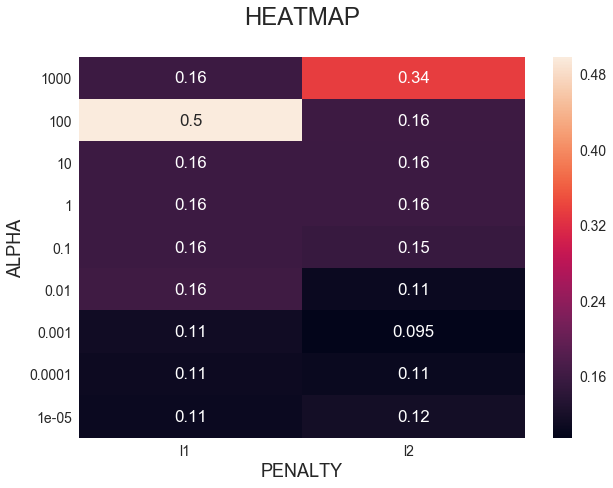

In [75]:
data=np.reshape(cv_errors, (9, 2))
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()



The accuracy of the lr is 90.787225%

The f1 score of the lr is 80.784780%

The recall score of the is 77.298887%

The precision score of the lr is 86.277197%


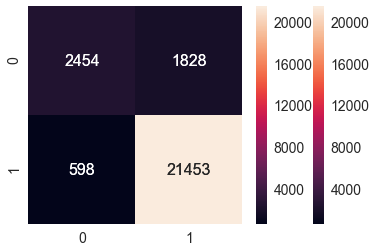

In [76]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [77]:
from sklearn.model_selection import RandomizedSearchCV
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.001}
Best Accuracy: 90.54%


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.6s finished


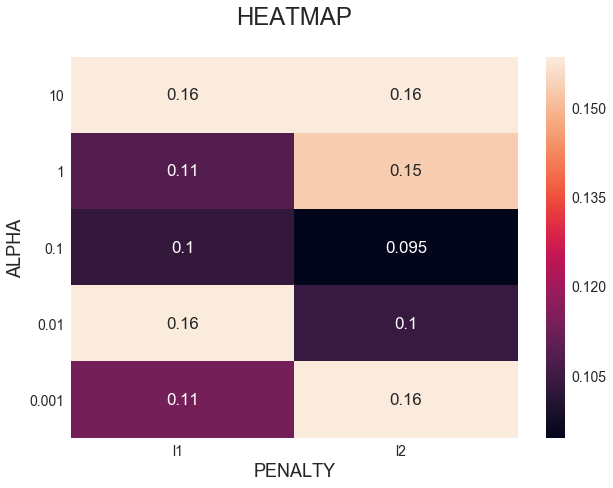

In [78]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (5, 2))
alpha=[10,1,0.1,0.01,0.001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 90.992291%

The f1 score of the lr is 80.706718%

The recall score of the is 76.602720%

The precision score of the lr is 87.835732%


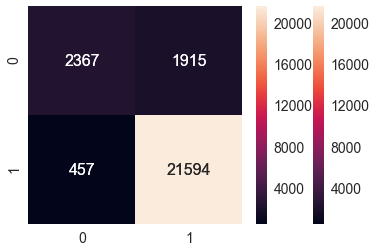

In [79]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

			Positive						Negative
________________________________________________________________________________________________
	-0.9857	worst          				0.6311	amaz           
	-0.8686	terribl        				0.5888	delici         
	-0.8426	aw             				0.5856	excel          
	-0.7970	disappoint     				0.5791	perfect        
	-0.7808	horribl        				0.5140	best           
	-0.6767	return         				0.4912	awesom         
	-0.6702	threw          				0.4685	great          
	-0.6409	bland          				0.4620	nice           
	-0.6376	disgust        				0.4587	worri          
	-0.6311	wast           				0.4164	complaint      
	-0.6246	unfortun       				0.4132	addict         
	-0.6018	stale          				0.4067	beat           
	-0.5856	cancel         				0.4034	fantast        
	-0.5726	sorri          				0.4001	thank          
	-0.5498	weak           				0.3969	glad           
	-0.5400	bewar          				0.3871	yummi          
	-0.5400	tasteless      				0.3871	satisfi        
	-0.5368	p

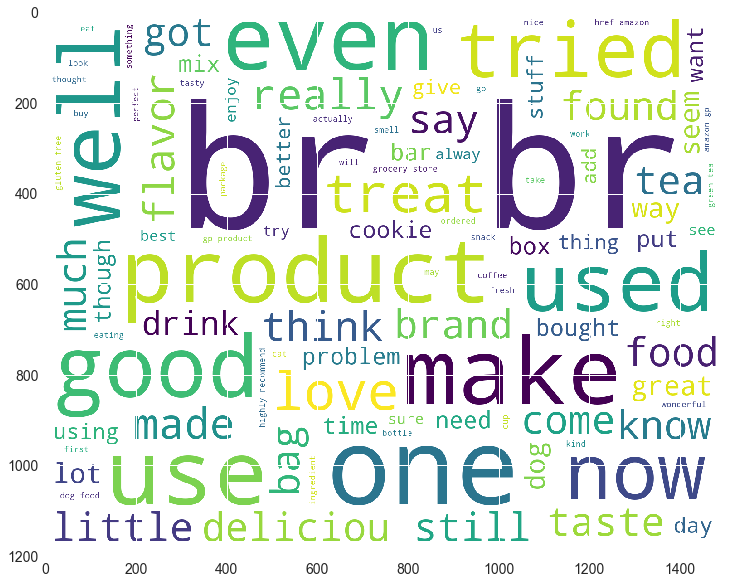

In [80]:
def show_most_informative_features(vectorizer, clf, n=25):
    d = {}
    a=0
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        d[a]=fn_1
        a+=1
    
show_most_informative_features(bow,clf)
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(final['Text']))

plt.figure(figsize=(20,10))
plt.imshow(wc)


In [81]:
X = final["CleanedText"]
y = final["Score"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [82]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train = tf_idf_vect.fit_transform(X_train)

In [83]:
x_test = tf_idf_vect.transform(x_test)


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.8s finished


Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy: 90.73%


In [85]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors

[0.15908203124999998,
 0.49814453125,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15908203124999998,
 0.15903320312500002,
 0.15788574218749996,
 0.09658203124999998,
 0.0926513671875,
 0.09650878906250004,
 0.09384765625000002]

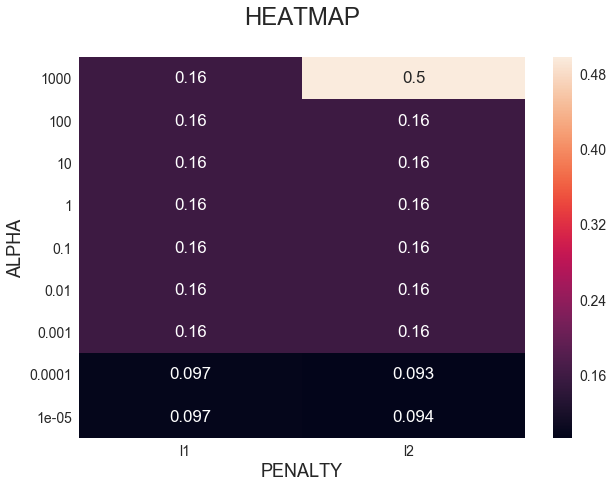

In [86]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (9, 2))
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 90.620134%

The f1 score of the lr is 78.517636%

The recall score of the is 73.388345%

The precision score of the lr is 90.173282%


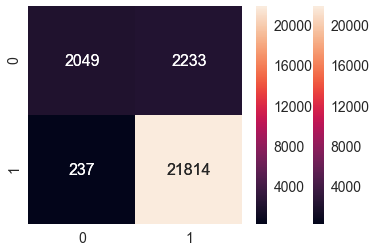

In [87]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.0001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [88]:
from sklearn.model_selection import RandomizedSearchCV
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy: 90.81%


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    9.2s finished


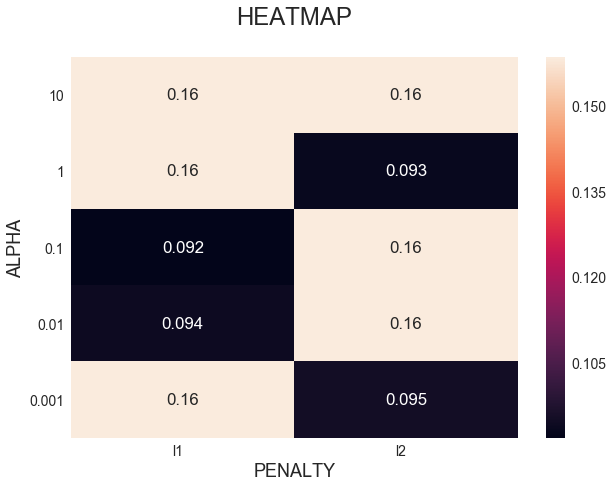

In [89]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (5, 2))
alpha=[10,1,0.1,0.01,0.001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 90.566969%

The f1 score of the lr is 78.384584%

The recall score of the is 73.271917%

The precision score of the lr is 90.036705%


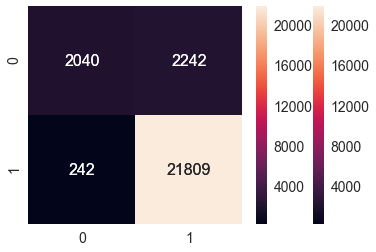

In [90]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.0001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

			Positive						Negative
________________________________________________________________________________________________
	-4.1058	disappoint     				3.9359	great          
	-3.4015	worst          				3.0534	best           
	-3.3698	terribl        				2.9113	delici         
	-3.2170	return         				2.8803	love           
	-3.1353	aw             				2.5755	good           
	-3.1111	horribl        				2.3508	perfect        
	-2.6196	wast           				2.2624	nice           
	-2.5122	threw          				2.2539	excel          
	-2.4811	disgust        				2.1213	amaz           
	-2.4239	unfortun       				1.8512	favorit        
	-2.3476	bland          				1.7584	wonder         
	-2.3317	stale          				1.7119	find           
	-2.2622	money          				1.6465	awesom         
	-2.2184	refund         				1.5834	tasti          
	-2.1404	bad            				1.5673	keep           
	-1.9244	wors           				1.5543	thank          
	-1.9031	weak           				1.5248	easi           
	-1.8822	s

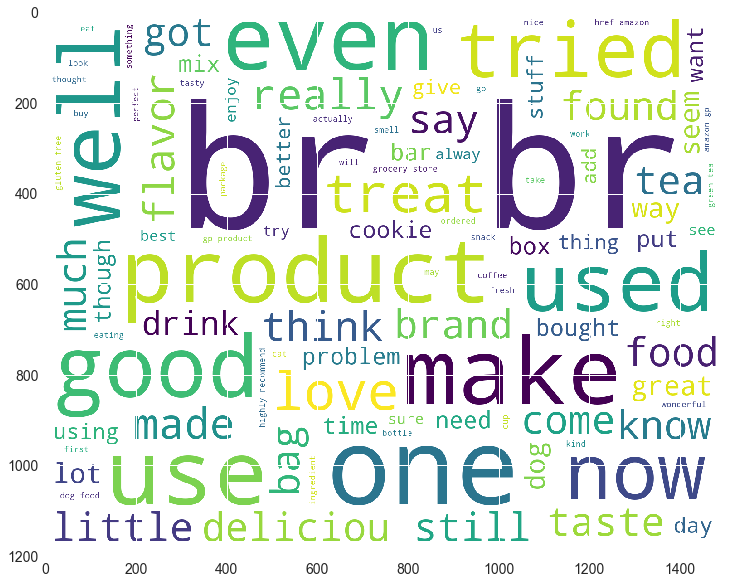

In [91]:
show_most_informative_features(tf_idf_vect,clf)
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(final['Text']))

plt.figure(figsize=(20,10))
plt.imshow(wc)


In [127]:
from sklearn.model_selection import train_test_split
X = final["Text"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test =train_test_split(X, y.values, test_size = 0.3, shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [128]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)    

In [129]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [130]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

61442
50
26333
50


In [131]:
X_train = sent_vectors
x_test = sent_vectors_test

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   34.8s finished


Best HyperParameter:  {'alpha': 0.001, 'penalty': 'l2'}
Best Accuracy: 87.19%


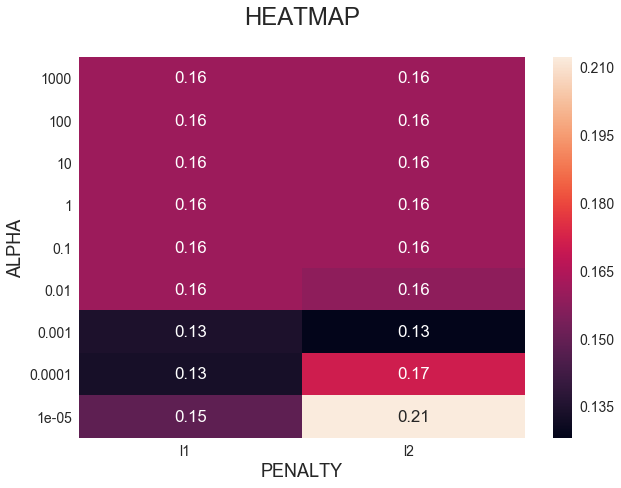

In [98]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (9, 2))
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 86.636540%

The f1 score of the lr is 65.904321%

The recall score of the is 62.453193%

The precision score of the lr is 81.335865%


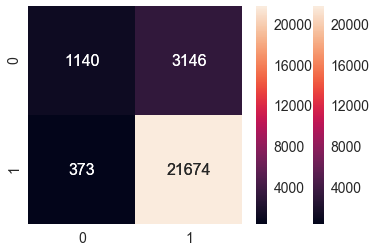

In [99]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [100]:
from sklearn.model_selection import RandomizedSearchCV
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.001}
Best Accuracy: 87.00%


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    9.7s finished


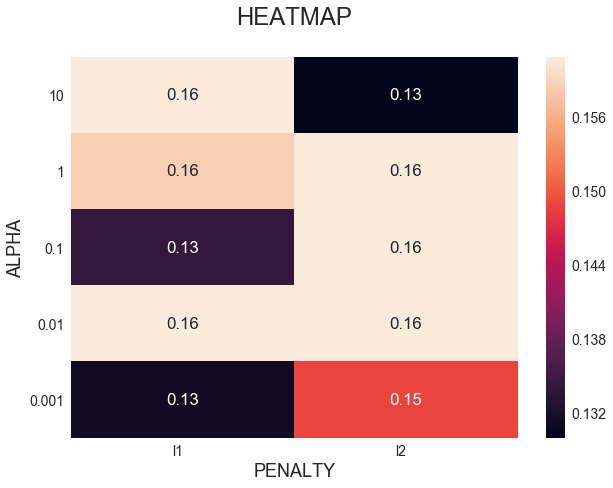

In [101]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (5, 2))
alpha=[10,1,0.1,0.01,0.001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 87.418828%

The f1 score of the lr is 71.331632%

The recall score of the is 67.685166%

The precision score of the lr is 79.985227%


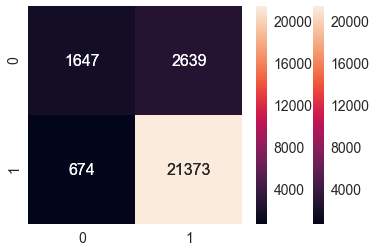

In [102]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [132]:
w2v_words = list(w2v_model.wv.vocab)
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [133]:
X_train = tfidf_sent_vectors


In [134]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [135]:
x_test = tfidf_sent_vectors_test
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    4.6s finished


Best HyperParameter:  {'alpha': 0.1, 'penalty': 'l2'}
Best Accuracy: 78.33%


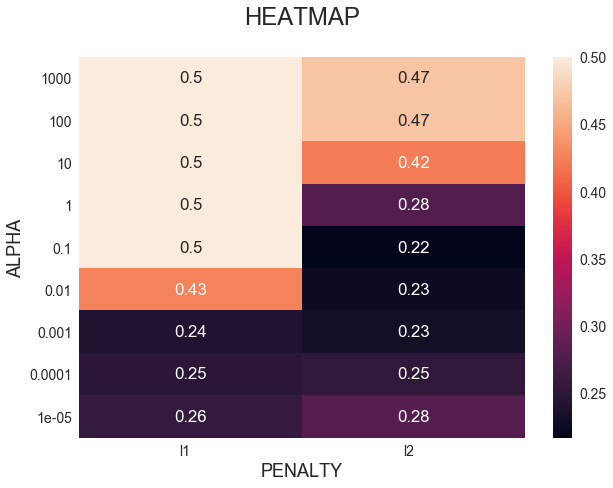

In [137]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (9, 2))
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 83.685869%

The f1 score of the lr is 45.605375%

The recall score of the is 50.023267%

The precision score of the lr is 91.842315%


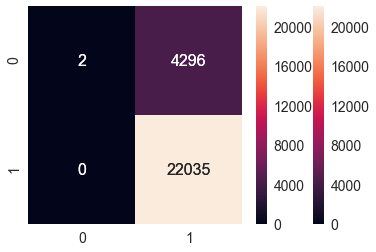

In [149]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l2')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [148]:
from sklearn.model_selection import RandomizedSearchCV
clf = SGDClassifier(loss='hinge')
#params we need to try on classifier
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=2) #For time based splitting
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HyperParameter:  {'penalty': 'l1', 'alpha': 0.001}
Best Accuracy: 83.95%


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.2s finished


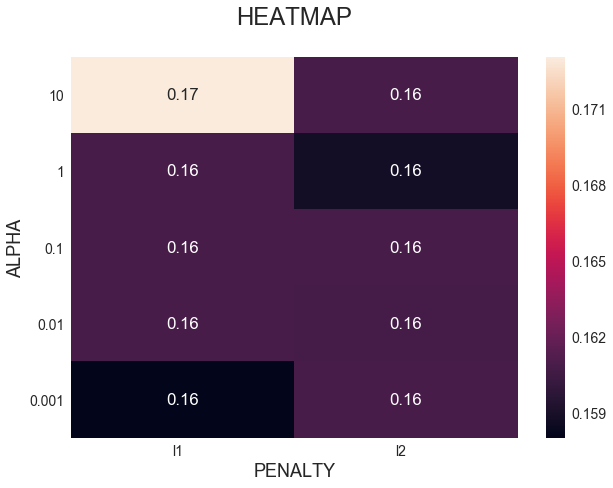

In [119]:
cv_errors = [1-i for i in gsv.cv_results_['mean_test_score']]
cv_errors
data=np.reshape(cv_errors, (5, 2))
alpha=[10,1,0.1,0.01,0.001]
penalty=['l1','l2']

fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(alpha, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(penalty, rotation=0, ha='right', fontsize=14)
plt.ylabel('ALPHA',size=18)
plt.xlabel('PENALTY',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()


The accuracy of the lr is 83.685869%

The f1 score of the lr is 45.605375%

The recall score of the is 50.023267%

The precision score of the lr is 91.842315%


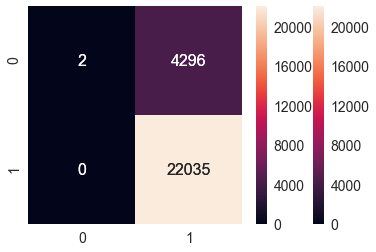

In [157]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf = SGDClassifier(loss='hinge',alpha=0.001,penalty='l1')
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr is %f%%' % (acc))
print('\nThe f1 score of the lr is %f%%' % (f1))
print('\nThe recall score of the is %f%%' % (r))
print('\nThe precision score of the lr is %f%%' % (p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [158]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Penalty", "Hyper parameter", "accuracy", "f1 score","recall","precision score"]
x.add_row(["BOW", "l2",0.001,90.26,81.40,79.91,83.19])
x.add_row(["RANDOM SEARCH BOW","l2", 0.001,90.28,81.46,79.98,83.22])
x.add_row(["TFIDF","l2", 0.001,91.13,82.58,80.19,85.73])
x.add_row(["RANDOM SEARCH TFIDF","l2",0.001,91.13,82.58,80.19,85.73])
x.add_row(["AVGW2V","l2", 0.1,86.54,70.39,67.21,77.44])
x.add_row(["RANDOM SEARCH AVGW2V","l1", 0.001,86.52,70.32,67.13,77.43])
print(x)


+----------------------+---------+-----------------+----------+----------+--------+-----------------+
|        Model         | Penalty | Hyper parameter | accuracy | f1 score | recall | precision score |
+----------------------+---------+-----------------+----------+----------+--------+-----------------+
|         BOW          |    l2   |      0.001      |  90.26   |   81.4   | 79.91  |      83.19      |
|  RANDOM SEARCH BOW   |    l2   |      0.001      |  90.28   |  81.46   | 79.98  |      83.22      |
|        TFIDF         |    l2   |      0.001      |  91.13   |  82.58   | 80.19  |      85.73      |
| RANDOM SEARCH TFIDF  |    l2   |      0.001      |  91.13   |  82.58   | 80.19  |      85.73      |
|        AVGW2V        |    l2   |       0.1       |  86.54   |  70.39   | 67.21  |      77.44      |
| RANDOM SEARCH AVGW2V |    l1   |      0.001      |  86.52   |  70.32   | 67.13  |      77.43      |
+----------------------+---------+-----------------+----------+----------+--------